# HMGCS2
[ 3-hydroxy-3-methylglutaryl-CoA synthase-2 deficiency (HMGCS2D)](https://omim.org/entry/605911) is caused by homozygous or compound heterozygous mutation in the HMGCS2 gene.

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.6.1.dev0


# MANE

In [2]:
gene_symbol = 'HMGCS2'
mane_tx_id = 'NM_005518.4'
mane_protein_id = "NP_005509.1" # hydroxymethylglutaryl-CoA synthase, mitochondrial isoform 1 precursor

In [3]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.29'  # Update, if necessary
#registry = configure_phenopacket_registry()

#with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
#    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
from pyphetools.visualization import PhenopacketIngestor
HMGCS2_dir = "/Users/robin/GIT/phenopacket-store/notebooks/HMGCS2/phenopackets"
ingestor = PhenopacketIngestor(indir=HMGCS2_dir)
ppkt_list = ingestor.get_phenopacket_list()
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=ppkt_list, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')
qc.summarize()

[pyphetools] Ingested 40 GA4GH phenopackets.
Individuals Processed: 100%|██████████| 40/40 [01:08<00:00,  1.71s/individuals]
Loaded 40 individuals
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #0
    diseases
      #0
       warnings:

  patient #12
    diseases
      #0
       warnings:

  patient #21
    diseases
      #0
       warnings:

  patient #22
    phenotype-features
      #12
       warnings:

    diseases
      #0
       warnings:

  patient #27
    diseases
      #0
       warnings:

  patient #37
    diseases
      #0
       warnings:

  patient #39
    phenotype-features
      #4
       warnings:

    diseases
      #0
       warnings:



In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Hypoglycemia,HP:0001943,35
Metabolic acidosis,HP:0001942,30
Dicarboxylic aciduria,HP:0003215,29
Hepatomegaly,HP:0002240,25
Elevated circulating alanine aminotransferase concentration,HP:0031964,22
Elevated circulating aspartate aminotransferase concentration,HP:0031956,20
Coma,HP:0001259,16
Seizure,HP:0001250,16
Vomiting,HP:0002013,14
Elevated circulating acetylcarnitine concentration,HP:0035023,12


<Axes: title={'center': 'Hydroxymethylglutaryl-CoA synthase, mitochondrial\ntranscript: NM_005518.4, protein: NP_005509.1'}>

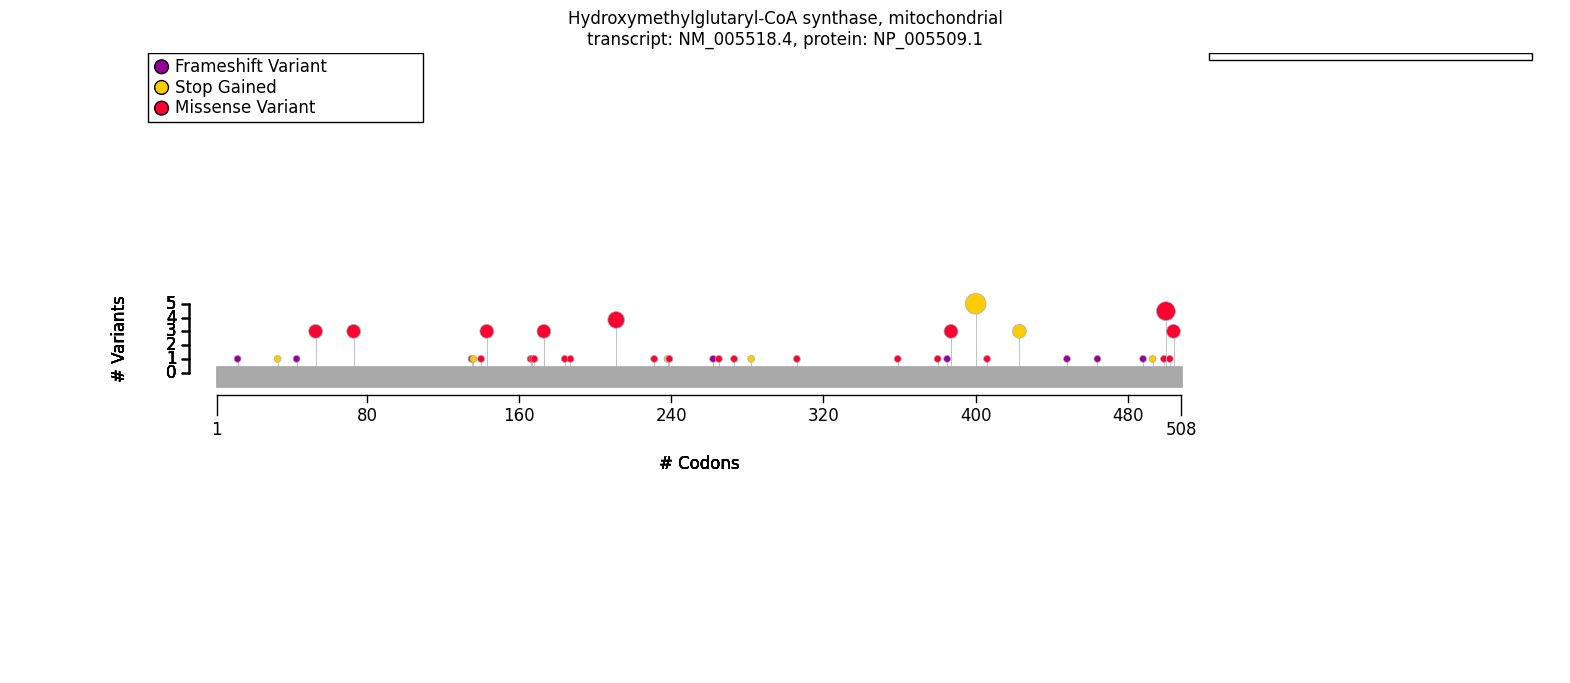

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService, configure_default_protein_metadata_service
from gpsea.model import ProteinMetadata
from gpsea.view import ProteinVisualizable, ProteinVisualizer

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id) 
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)
drawer = ProteinVisualizer()
drawer.draw_fig(pvis=pvis)


In [7]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Variant key,Variant (cDNA),Variant (protein),Overlapping Exons,Effects,Count
SO:1000029_HGNC:5008_HMGCS2,SV involving HMGCS2,p.?,,chromosomal deletion,6
1_119753373_119753373_C_A,c.1201G>T,p.Glu401Ter,7,stop gained,5
1_119759915_119759915_C_T,c.634G>A,p.Gly212Arg,3,missense,3
1_119764211_119764211_A_G,c.520T>C,p.Phe174Leu,2,missense,2
1_119764511_119764511_C_T,c.220G>A,p.Glu74Lys,2,missense,2
1_119764571_119764571_C_T,c.160G>A,p.Val54Met,2,missense,2
1_119755452_119755452_C_T,c.1162G>A,p.Gly388Arg,6,missense,2
1_119750827_119750827_C_T,c.1502G>A,p.Arg501Gln,9,missense,2
1_119764171_119764171_C_A,c.559+1G>T,None,None,splice donor,2
1_119750827_119750827_C_G,c.1502G>C,p.Arg501Pro,9,missense,2


In [8]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
len(pheno_predicates)
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter( hpo=hpo)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
from gpsea.analysis.pcats.stats import FisherExactTest

count_statistic = FisherExactTest()
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
     mtc_alpha=mtc_alpha,
)

In [9]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, biallelic_predicate

missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)


gt_predicate = biallelic_predicate(a_predicate=missense, 
                                   b_predicate=~missense, 
                                   a_label="missense",
                                   b_label="other",
                                    partitions=((0,1),(2,))
                                   )
print(gt_predicate.display_question())
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Allele group: missense/missense OR missense/other, other/other


Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,2
HMF03,Skipping term because of a child term with the same individual counts,3
HMF08,Skipping general term,42
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,74


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                       missense/missense OR missense/other  \
                                                                                 Count   
Hepatomegaly [HP:0002240]                                                        14/17   
Vomiting [HP:0002013]                                                             8/11   
Metabolic acidosis [HP:0001942]                                                  18/20   
Elevated circulating alanine aminotransferase c...                               14/17   
Coma [HP:0001259]                                                                12/16   
Seizure [HP:0001250]                                                             12/17   
Reduced consciousness [HP:0004372]                                               12/12   
Hypoglycemia [HP:0001943]                                                        23/26   
Abnormal blood glucose concentration [HP:0011015]                                23/23   
Acidosis [HP:0001941]                                                            18/18   
Abnormal liver morphology [HP:0410042]                                           14/14   
Visceromegaly [HP:0003271]                                                       14/14   
Elevated circulating aspartate aminotransferase...                               13/15   
Elevated circulating hepatic transaminase conce...                               15/16   
Abnormal circulating hepatic transaminase conce...                               15/15   
Dicarboxylic aciduria [HP:0003215]                                               19/20   
Elevated urinary carboxylic acid [HP:0040156]                                    19/19   
Abnormal circulating fatty-acid concentration [...                               14/14   
Abnormal circulating lipid concentration [HP:00...                               15/15   

Allele group                                               other/other  \
                                                   Percent       Count   
Hepatomegaly [HP:0002240]                              82%       11/11   
Vomiting [HP:0002013]                                  73%         6/6   
Metabolic acidosis [HP:0001942]                        90%       12/12   
Elevated circulating alanine aminotransferase c...     82%         8/8   
Coma [HP:0001259]                                      75%         4/4   
Seizure [HP:0001250]                                   71%         4/7   
Reduced consciousness [HP:0004372]                    100%         4/4   
Hypoglycemia [HP:0001943]                              88%       12/13   
Abnormal blood glucose concentration [HP:0011015]     100%       12/12   
Acidosis [HP:0001941]                                 100%       12/12   
Abnormal liver morphology [HP:0410042]                100%       11/11   
Visceromegaly [HP:0003271]                            100%       11/11   
Elevated circulating aspartate aminotransferase...     87%         7/7   
Elevated circulating hepatic transaminase conce...     94%         8/8   
Abnormal circulating hepatic transaminase conce...    100%         8/8   
Dicarboxylic aciduria [HP:0003215]                     95%       13/13   
Elevated urinary carboxylic acid [HP:0040156]         100%       13/13   
Abnormal circulating fatty-acid concentration [...    100%       10/10   
Abnormal circulating lipid concentration [HP:00...    100%       11/11   

Allele group                                                                   \
                                                   Percent Corrected p values   
Hepatomegaly [HP:0002240]                             100%                1.0   
Vomiting [HP:0002013]                                 100%                1.0   
Metabolic acidosis [HP:0001942]                       100%                1.0   
Elevated circulating alanine aminotransferase c...    100%                1.0   
Coma [HP:0001259]                                     100%          

In [12]:
from gpsea.analysis.temporal.endpoint import disease_onset
disease_id = "OMIM:605911"  # HMG-CoA synthase-2 deficiency	
endpoint = disease_onset(disease_id=disease_id)
endpoint.display_question()

'Compute time until postnatal diagnosis of OMIM:605911'

In [13]:
from gpsea.analysis.temporal.stats import LogRankTest
survival_statistic = LogRankTest()

from gpsea.analysis.temporal import SurvivalAnalysis
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)

result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_predicate=gt_predicate,
    endpoint=endpoint,
)

In [15]:
result.pval

0.5268285514931716

In [17]:
from gpsea.analysis.predicate.genotype import sex_predicate
mf_predicate = sex_predicate()
mf_predicate.display_question()

result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_predicate=mf_predicate,
    endpoint=endpoint,
)
print("M/F p-value", result.pval)

mf_fte_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=mf_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=mf_fte_result)

M/F p-value 0.2578890864055736


Sex of the individual                              FEMALE           MALE  \
                                                    Count Percent  Count   
Metabolic acidosis [HP:0001942]                     12/12    100%    7/9   
Dicarboxylic aciduria [HP:0003215]                  14/14    100%  11/12   
Hepatomegaly [HP:0002240]                           11/12     92%   9/11   
Seizure [HP:0001250]                                 5/10     50%    5/8   
Hypoglycemia [HP:0001943]                           11/13     85%  11/13   
Abnormal blood glucose concentration [HP:0011015]   11/11    100%  11/11   
Acidosis [HP:0001941]                               12/12    100%    7/7   
Abnormal liver morphology [HP:0410042]              11/11    100%    9/9   
Visceromegaly [HP:0003271]                          11/11    100%    9/9   
Elevated circulating aspartate aminotransferase...  10/11     91%  10/11   
Elevated circulating hepatic transaminase conce...  12/13     92%  11/11   
Abnormal circulating hepatic transaminase conce...  12/12    100%  11/11   
Elevated circulating alanine aminotransferase c...  11/12     92%  11/13   
Elevated urinary carboxylic acid [HP:0040156]       14/14    100%  11/11   
Abnormal circulating fatty-acid concentration [...    9/9    100%    9/9   
Abnormal circulating lipid concentration [HP:00...  10/10    100%  10/10   
Vomiting [HP:0002013]                                9/11     82%    5/6   

Sex of the individual                                                          \
                                                   Percent Corrected p values   
Metabolic acidosis [HP:0001942]                        78%                1.0   
Dicarboxylic aciduria [HP:0003215]                     92%                1.0   
Hepatomegaly [HP:0002240]                              82%                1.0   
Seizure [HP:0001250]                                   62%                1.0   
Hypoglycemia [HP:0001943]                              85%                1.0   
Abnormal blood glucose concentration [HP:0011015]     100%                1.0   
Acidosis [HP:0001941]                                 100%                1.0   
Abnormal liver morphology [HP:0410042]                100%                1.0   
Visceromegaly [HP:0003271]                            100%                1.0   
Elevated circulating aspartate aminotransferase...     91%                1.0   
Elevated circulating hepatic transaminase conce...    100%                1.0   
Abnormal circulating hepatic transaminase conce...    100%                1.0   
Elevated circulating alanine aminotransferase c...     85%                1.0   
Elevated urinary carboxylic acid [HP:0040156]         100%                1.0   
Abnormal circulating fatty-acid concentration [...    100%                1.0   
Abnormal circulating lipid concentration [HP:00...    100%                1.0   
Vomiting [HP:0002013]                                  83%                1.0   

Sex of the individual                                         
                                                    p values  
Metabolic acidosis [HP:0001942]                     0.171429  
Dicarboxylic aciduria [HP:0003215]                  0.461538  
Hepatomegaly [HP:0002240]                           0.590062  
Seizure [HP:0001250]                                0.664061  
Hypoglycemia [HP:0001943]                           1.000000  
Abnormal blood glucose concentration [HP:0011015]   1.000000  
Acidosis [HP:0001941]                               1.000000  
Abnormal liver morphology [HP:0410042]              1.000000  
Visceromegaly [HP:0003271]                          1.000000  
Elevated circulating aspartate aminotransferase...  1.000000  
Elevated circulating hepatic transaminase conce...  1.000000  
Abnormal circulating hepatic transaminase conce...  1.000000  
Elevated circulating alanine aminotransferase c...  1.000000  
Elevated urinary carboxylic acid [HP:0040156]       1.000000  
Abnorma